In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import TOFPET_cal_lib as TPcal
from scipy import interpolate
import time
import build_data_df_mine as bd
from functools import partial
import multiprocessing as mp

%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [2]:
def event_selection(df,column):
    max_pos = df[column].argmax()
    res1 = df.iloc[max_pos]['sensor_id'] in [44,45,54,55]
    
    df_aux = df['sensor_id'].isin([11,12,13,14,15,16,17,18,21,28,31,38,41,48,
                                   51,58,61,68,71,78,81,82,83,84,85,86,87,88])
    if df_aux.any():
        res2 = False
    else:
        res2 = True
        
    return res1  & res2

In [3]:
def event_selection_center(df,column):
    max_pos = df[column].argmax()
    res1 = df.iloc[max_pos]['sensor_id'] in [44,45,54,55]
    return res1

In [4]:
def exp_tot(x,A,B):
    
    return A*np.exp(x*5/B)

In [5]:
def ToT2pe(x,df_ToT2pe):
    return df_ToT2pe.iloc[(np.abs(df_ToT2pe['ToT_ns']-x*5)).argmin()]['pe']
    

In [6]:
run = 11301 
#run = 11293
asic = 0
path_data = "/analysis/" + str(run) + "/hdf5/proc/linear_interp/files/"
#path_data = "/home/vherrero/CALIBRATION_FILES/"

In [7]:
def pre_process(run_number,file_number):
    
    hi_ToT = 500
    lo_ToT = 0
    
    energy1_array = []
    energy2_array = []
    energy3_array = []
        
    file_data = path_data + 'run_' + str(run_number) +\
                    '_'+ str(file_number).zfill(4) + '_trigger1_waveforms.h5'

    with pd.HDFStore(file_data,'r',complib="zlib",complevel=4) as storage:
        keys = storage.keys()
        for j in [keys[i] for i in range(10)]:
            print("File %i | Chunk %s" % (file_number,j))
            data = pd.read_hdf(file_data,j) #,stop=10000)

            # Apply Filtering
            #data_f = data[(data['intg_w']<hi_intg_w)&(data['intg_w']>lo_intg_w) & (data['cluster']!=-1) ]
            data_f = data[(data['cluster']!=-1)] 
            
            # Coincidence Filter
            coincidence   = data_f.groupby(['cluster','evt_number'])['tofpet_id'].nunique()
            data_f_idx    = data_f.set_index(['cluster','evt_number'])
            data_f        = data_f_idx.loc[coincidence[coincidence == 2].index]
            
            # Only TOFPET0
            data_f0 = data_f.loc[(data_f['tofpet_id']==0)]
            
            # ToT computation
            data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
            
            # Get rid of abnormaly long ToT
            data_f0 = data_f0[(data_f0['intg_w_ToT']>lo_ToT) & (data_f0['intg_w_ToT']<hi_ToT)]
            
            # Event selection based on Maximum Charge
            sel = data_f0.groupby(['cluster','evt_number']).apply(event_selection_center,column='intg_w_ToT')
            data_f1 = data_f0[sel]
                                   
            energy1 = data_f1.groupby(['cluster','evt_number'], as_index = False)['intg_w_ToT'].sum()
                
            energy1_array.extend(energy1['intg_w_ToT'].to_numpy())           
        
    return energy1_array, data_f1

In [56]:
def process_energy(run_number,table,file_number):
    
    #hi_ToT = 500
    #lo_ToT = 0
    
    lo_ToT = table.iloc[0]['ToT_ns']/5.0
    hi_ToT = table.iloc[-1]['ToT_ns']/5.0
    
    energy1_array = []
    energy2_array = []
    energy3_array = []
    data_df_aux = []
        
    file_data = path_data + 'run_' + str(run_number) +\
                    '_'+ str(file_number).zfill(4) + '_trigger1_waveforms.h5'

    with pd.HDFStore(file_data,'r',complib="zlib",complevel=4) as storage:
        keys = storage.keys()
        for j in [keys[i] for i in range(10)]:
            print("File %i | Chunk %s" % (file_number,j))
            data = pd.read_hdf(file_data,j) #,stop=10000)

            # Apply Filtering
            #data_f = data[(data['intg_w']<hi_intg_w)&(data['intg_w']>lo_intg_w) & (data['cluster']!=-1) ]
            data_f = data[(data['cluster']!=-1)] 
            
            # Coincidence Filter
            coincidence   = data_f.groupby(['cluster','evt_number'])['tofpet_id'].nunique()
            data_f_idx    = data_f.set_index(['cluster','evt_number'])
            data_f        = data_f_idx.loc[coincidence[coincidence == 2].index]
            
            # Only TOFPET0
            data_f0 = data_f.loc[(data_f['tofpet_id']==0)]
            
            # ToT computation
            data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
            
            # Get rid of abnormaly long ToT
            data_f0 = data_f0[(data_f0['intg_w_ToT']>lo_ToT) & (data_f0['intg_w_ToT']<hi_ToT)]
            
            # Event selection based on Maximum Charge
            sel = data_f0.groupby(['cluster','evt_number']).apply(event_selection_center,column='intg_w_ToT')
            data_f1 = data_f0[sel]
            #data_f0['ToT_pe'] = data_f0['intg_w'].apply(exp_tot, A=0.21193678,B=50.07888458)
            data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
                                   
            energy1 = data_f1.groupby(['cluster','evt_number'], as_index = False)['intg_w_ToT'].sum()
            energy2 = data_f1.groupby(['cluster','evt_number'], as_index = False)['intg_w'].sum()
            energy3 = data_f1.groupby(['cluster','evt_number'], as_index = False)['ToT_pe'].sum()
            
            energy1_array.extend(energy1['intg_w_ToT'].to_numpy())           
            energy2_array.extend(energy2['intg_w'].to_numpy())
            energy3_array.extend(energy3['ToT_pe'].to_numpy())
            data_df_aux.append(data_f1)
            data_df_T = pd.concat(data_df_aux)
        
    return energy1_array, energy2_array, energy3_array, data_df_T

In [9]:
def post_process(filename,table_name):
    
    #path_out             = "/home/vherrero/RESULTS/"
    #filename_processed   = "run_"+str(run)+"_results_d.h5"
    
    table = pd.read_hdf("/home/vherrero/CALIBRATION_FILES/" + table_name,'/ToT_T2')
    data_f0 = pd.read_hdf(filename,'df_out')
    
    lo_ToT = table.iloc[0]['ToT_ns']/5.0
    hi_ToT = table.iloc[-1]['ToT_ns']/5.0
    
    print(lo_ToT,hi_ToT)
    
    energy1_array = []
    energy3_array = []
       
    # ToT filtering (based on table data)
    #data_f0 = data_f0[(data_f0['intg_w_ToT']>lo_ToT) & (data_f0['intg_w_ToT']<hi_ToT)]
    #print("ToT filtering applied")
    
    print("New ToT_pe table")
    data_f0['ToT_pe'] = data_f0['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
    
    print("Computing Energy")
    energy1 = data_f0.groupby(['cluster','evt_number'], as_index = False)['intg_w_ToT'].sum()
    energy3 = data_f0.groupby(['cluster','evt_number'], as_index = False)['ToT_pe'].sum()
    
    
    energy1_array = energy1['intg_w_ToT'].to_numpy()
    energy3_array = energy3['ToT_pe'].to_numpy()
        
    return energy1_array, energy3_array, data_f0

# Preprocessing to find mean ToT for Max SiPM (50pe according MC) 

In [10]:
n_files = 40

out1 = []
df_array = []

process_energy_mp = partial(pre_process,run) 

pool = mp.Pool(processes = n_files)

pool_output = pool.map(process_energy_mp, range(n_files))

pool.close()
pool.join()

sizes = np.shape(pool_output)

for x in range(sizes[0]):
    out1.extend(pool_output[x][0])
    df_array.append(pool_output[x][1])
        
out1   = np.array(out1)
df_out = pd.concat(df_array)

File 12 | Chunk /data_0
File 6 | Chunk /data_0
File 11 | Chunk /data_0
File 39 | Chunk /data_0
File 37 | Chunk /data_0
File 33 | Chunk /data_0
File 19 | Chunk /data_0
File 34 | Chunk /data_0
File 7 | Chunk /data_0
File 21 | Chunk /data_0
File 38 | Chunk /data_0
File 22 | Chunk /data_0
File 25 | Chunk /data_0
File 32 | Chunk /data_0File 30 | Chunk /data_0
File 29 | Chunk /data_0File 23 | Chunk /data_0


File 35 | Chunk /data_0File 27 | Chunk /data_0File 26 | Chunk /data_0
File 36 | Chunk /data_0


File 14 | Chunk /data_0File 15 | Chunk /data_0

File 24 | Chunk /data_0
File 0 | Chunk /data_0
File 28 | Chunk /data_0
File 17 | Chunk /data_0File 10 | Chunk /data_0File 8 | Chunk /data_0


File 5 | Chunk /data_0
File 2 | Chunk /data_0
File 20 | Chunk /data_0
File 31 | Chunk /data_0
File 9 | Chunk /data_0
File 3 | Chunk /data_0File 13 | Chunk /data_0

File 4 | Chunk /data_0
File 1 | Chunk /data_0
File 16 | Chunk /data_0
File 18 | Chunk /data_0


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 36 | Chunk /data_1
File 17 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 31 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 1 | Chunk /data_1
File 20 | Chunk /data_1File 24 | Chunk /data_1

File 10 | Chunk /data_1
File 16 | Chunk /data_1File 2 | Chunk /data_1

File 27 | Chunk /data_1
File 3 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 13 | Chunk /data_1

<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']



File 4 | Chunk /data_1
File 28 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



File 29 | Chunk /data_1
File 7 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 39 | Chunk /data_1
File 23 | Chunk /data_1
File 26 | Chunk /data_1
File 21 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 15 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 8 | Chunk /data_1
File 11 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 5 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A val

File 30 | Chunk /data_1
File 32 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 12 | Chunk /data_1
File 33 | Chunk /data_1
File 35 | Chunk /data_1
File 34 | Chunk /data_1
File 22 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 37 | Chunk /data_1

<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 25 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 14 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 19 | Chunk /data_1
File 0 | Chunk /data_1
File 38 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 6 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 18 | Chunk /data_1


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 36 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 20 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 1 | Chunk /data_10
File 31 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 27 | Chunk /data_10
File 3 | Chunk /data_10
File 16 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 28 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 9 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 13 | Chunk /data_10
File 2 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 10 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 29 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 39 | Chunk /data_10File 21 | Chunk /data_10



<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 4 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 24 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 8 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 15 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 26 | Chunk /data_10
File 5 | Chunk /data_10
File 7 | Chunk /data_10File 17 | Chunk /data_10



<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 23 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 11 | Chunk /data_10
File 32 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 38 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 19 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 30 | Chunk /data_10
File 14 | Chunk /data_10
File 33 | Chunk /data_10
File 34 | Chunk /data_10
File 35 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 6 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 0 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 12 | Chunk /data_10

<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 36 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 18 | Chunk /data_10

<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']



File 37 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 20 | Chunk /data_100
File 22 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 25 | Chunk /data_10


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 27 | Chunk /data_100
File 3 | Chunk /data_100
File 16 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 1 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 31 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 2 | Chunk /data_100
File 28 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 10 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 13 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 29 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 15 | Chunk /data_100File 4 | Chunk /data_100



<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_100
File 39 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 8 | Chunk /data_100
File 24 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 5 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 21 | Chunk /data_100

<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']



File 26 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 17 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 7 | Chunk /data_100
File 11 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 32 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 23 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 30 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 36 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 14 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 19 | Chunk /data_100
File 38 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 18 | Chunk /data_100
File 34 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 33 | Chunk /data_100
File 6 | Chunk /data_100
File 12 | Chunk /data_100
File 0 | Chunk /data_100
File 20 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 35 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 3 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 27 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 37 | Chunk /data_100
File 16 | Chunk /data_101
File 28 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 1 | Chunk /data_101
File 25 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 2 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 31 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 13 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 10 | Chunk /data_101
File 22 | Chunk /data_100


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 15 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 9 | Chunk /data_101
File 24 | Chunk /data_101
File 8 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 4 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 17 | Chunk /data_101
File 29 | Chunk /data_101
File 5 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 11 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 39 | Chunk /data_101
File 21 | Chunk /data_101
File 26 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 36 | Chunk /data_102
File 7 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 32 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 20 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 38 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 14 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 30 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 23 | Chunk /data_101
File 27 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 3 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 12 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 6 | Chunk /data_101
File 33 | Chunk /data_101
File 16 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 1 | Chunk /data_102
File 18 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 28 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 19 | Chunk /data_101
File 2 | Chunk /data_102
File 31 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 0 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 13 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 34 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series ke

File 15 | Chunk /data_102
File 10 | Chunk /data_102
File 35 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 5 | Chunk /data_102
File 9 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 37 | Chunk /data_101
File 4 | Chunk /data_102
File 25 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 24 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 36 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 17 | Chunk /data_102
File 11 | Chunk /data_102
File 8 | Chunk /data_102
File 29 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 22 | Chunk /data_101


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 7 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 14 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 20 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 3 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 30 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 27 | Chunk /data_103
File 23 | Chunk /data_102
File 26 | Chunk /data_102
File 38 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 39 | Chunk /data_102
File 16 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 31 | Chunk /data_103
File 1 | Chunk /data_103
File 12 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 21 | Chunk /data_102
File 33 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 6 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 2 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 28 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 13 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 32 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 10 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 35 | Chunk /data_102
File 15 | Chunk /data_103
File 4 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 24 | Chunk /data_103
File 5 | Chunk /data_103
File 18 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 36 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 0 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 11 | Chunk /data_103
File 17 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 8 | Chunk /data_103
File 19 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 14 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 20 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 25 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 34 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 37 | Chunk /data_102

<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']



File 3 | Chunk /data_104
File 29 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 7 | Chunk /data_103

<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 16 | Chunk /data_104
File 31 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 27 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 1 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 28 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 13 | Chunk /data_104
File 23 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 22 | Chunk /data_102


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 2 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 38 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 12 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 33 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 9 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 10 | Chunk /data_104File 15 | Chunk /data_104

File 24 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 21 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 5 | Chunk /data_104
File 4 | Chunk /data_104
File 30 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 36 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 39 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 26 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 11 | Chunk /data_104
File 17 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 6 | Chunk /data_103
File 0 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 8 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 35 | Chunk /data_103
File 14 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 18 | Chunk /data_103
File 20 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 3 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 16 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 25 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 32 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 27 | Chunk /data_105
File 31 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 28 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 19 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 2 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 23 | Chunk /data_104
File 29 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 13 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 15 | Chunk /data_105
File 38 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 9 | Chunk /data_105
File 22 | Chunk /data_103
File 10 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 24 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 4 | Chunk /data_105
File 37 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 12 | Chunk /data_104
File 33 | Chunk /data_104
File 34 | Chunk /data_103


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 1 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 7 | Chunk /data_104
File 36 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 17 | Chunk /data_105
File 11 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 8 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 5 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 30 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 14 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 20 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 3 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 16 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 0 | Chunk /data_104
File 27 | Chunk /data_106
File 39 | Chunk /data_104
File 35 | Chunk /data_104

<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 21 | Chunk /data_104
File 31 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 28 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 25 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 18 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 15 | Chunk /data_106
File 9 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 26 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 24 | Chunk /data_106
File 13 | Chunk /data_106
File 4 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 6 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 2 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 23 | Chunk /data_105File 10 | Chunk /data_106



<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 32 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 1 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 38 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 17 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 11 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 12 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 33 | Chunk /data_105
File 22 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 8 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 19 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 14 | Chunk /data_106
File 37 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 29 | Chunk /data_105
File 30 | Chunk /data_105
File 5 | Chunk /data_106
File 34 | Chunk /data_104


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to b

File 7 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 0 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 35 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 25 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series ke

File 39 | Chunk /data_105
File 26 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 23 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 21 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 12 | Chunk /data_106
File 22 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 33 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 18 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 6 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 0 | Chunk /data_106
File 30 | Chunk /data_106
File 29 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 37 | Chunk /data_105
File 19 | Chunk /data_105


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

File 34 | Chunk /data_105
File 35 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 38 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 32 | Chunk /data_105
File 25 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 7 | Chunk /data_106
File 26 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 39 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

File 21 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 22 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 18 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 6 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['int

File 37 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 32 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series ke

File 19 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 34 | Chunk /data_106


<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-7-e09a3d979dd7>:39: UserWarning: Boolean Series key will be reindex

<IPython.core.display.Javascript object>


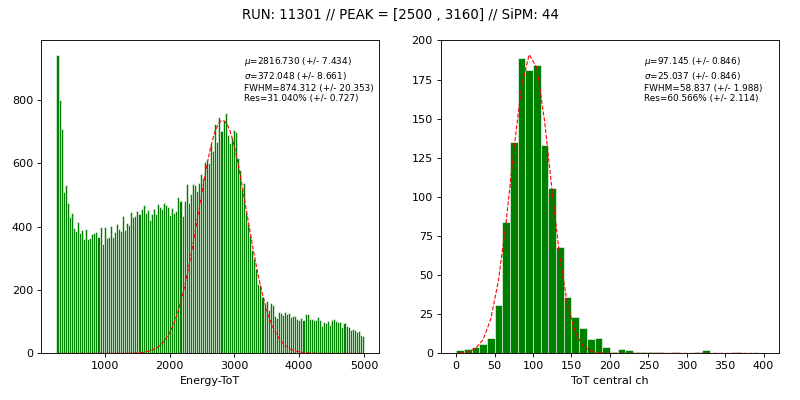

(array([ 735.96775302, 2816.7303189 ,  372.04755801]), array([8.36198654, 7.43393887, 8.6608351 ]), 1.5621423368025866)
(array([191.6465177 ,  97.14515776,  25.03704226]), array([5.60925063, 0.84616662, 0.84617004]), 29.39486709326308)


In [13]:
low  = 2500
high = 3160
sipm = 44

energy_w = df_out.groupby(['cluster','evt_number'])['intg_w_ToT'].sum()
df_filtered = df_out.loc[(energy_w>low) & (energy_w<high)]
ch_filtered = df_filtered.loc[df_filtered['sensor_id']==sipm]

fig, axis = plt.subplots(1,2,figsize=(10,5))
fig.suptitle(("RUN: %i" % run) + (" // PEAK = [%i , %i] // SiPM: %i" % (low,high,sipm)) )

axis[0].set_title("T2-T1")
coeff=TPcal.gauss_fit2(out1,150,True,axis[0],"Energy-ToT","","",[0.6,0.95,"left"]
                 ,[250,5000],[2500,3500],[125,2900,300])

axis[1].set_title("ToT")
coeff2=TPcal.gauss_fit2(ch_filtered['intg_w_ToT'],40,True,axis[1],"ToT central ch","","",[0.6,0.95,"left"],
                 [0,400],[0,200],[17,100,10])

plt.tight_layout()
print(coeff)
print(coeff2)

# SLOW PROCESSING

In [93]:
n_files = 40

path_out             = "/home/vherrero/CALIBRATION_FILES/"
filename_ToT_table   = "ToT_PE_conversion12a.h5"
table = pd.read_hdf(path_out + filename_ToT_table,'/ToT_T2')

out1 = []
out2 = []
out3 = []
df_array = []
#process_typical_charge_mp = partial(process_typical_charge,run) 
process_energy_mp = partial(process_energy,run,table) 
#process_max_charge_mp = partial(process_max_charge,run) 

pool = mp.Pool(processes = n_files)

#pool_output = pool.map(process_typical_charge_mp, range(n_files))
pool_output = pool.map(process_energy_mp, range(n_files))
#pool_output = pool.map(process_max_charge_mp, range(n_files))

pool.close()
pool.join()

sizes = np.shape(pool_output)

for x in range(sizes[0]):
    out1.extend(pool_output[x][0])
    out2.extend(pool_output[x][1])
    out3.extend(pool_output[x][2])
    df_array.append(pool_output[x][3])
        
out1   = np.array(out1)
out2   = np.array(out2)
out3   = np.array(out3)
df_out = pd.concat(df_array)


File 0 | Chunk /data_0
File 9 | Chunk /data_0File 10 | Chunk /data_0
File 5 | Chunk /data_0

File 11 | Chunk /data_0
File 12 | Chunk /data_0
File 13 | Chunk /data_0File 14 | Chunk /data_0

File 15 | Chunk /data_0File 16 | Chunk /data_0

File 1 | Chunk /data_0
File 17 | Chunk /data_0File 18 | Chunk /data_0

File 19 | Chunk /data_0
File 20 | Chunk /data_0
File 21 | Chunk /data_0File 8 | Chunk /data_0
File 2 | Chunk /data_0
File 7 | Chunk /data_0

File 3 | Chunk /data_0
File 32 | Chunk /data_0
File 22 | Chunk /data_0File 6 | Chunk /data_0File 4 | Chunk /data_0


File 36 | Chunk /data_0
File 34 | Chunk /data_0
File 33 | Chunk /data_0
File 27 | Chunk /data_0
File 37 | Chunk /data_0
File 38 | Chunk /data_0
File 24 | Chunk /data_0File 28 | Chunk /data_0
File 29 | Chunk /data_0

File 30 | Chunk /data_0
File 31 | Chunk /data_0
File 39 | Chunk /data_0File 25 | Chunk /data_0
File 26 | Chunk /data_0

File 23 | Chunk /data_0
File 35 | Chunk /data_0


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserW

File 2 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserW

File 1 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 26 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 23 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 4 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 17 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 33 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 36 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 38 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 35 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 13 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 39 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 5 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 27 | Chunk /data_1
File 34 | Chunk /data_1
File 16 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 31 | Chunk /data_1
File 25 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 8 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 9 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 21 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 10 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 32 | Chunk /data_1
File 19 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 3 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 15 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 11 | Chunk /data_1File 12 | Chunk /data_1



<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 20 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 6 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 0 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 14 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 30 | Chunk /data_1File 37 | Chunk /data_1

File 7 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 29 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 28 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 24 | Chunk /data_1


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 2 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserW

File 26 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: Setti

File 1 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 33 | Chunk /data_10
File 23 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 4 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 17 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 13 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 16 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 39 | Chunk /data_10

<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)



File 36 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 38 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 31 | Chunk /data_10
File 18 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 8 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 35 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 25 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 9 | Chunk /data_10
File 21 | Chunk /data_10File 3 | Chunk /data_10



<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 19 | Chunk /data_10
File 34 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 5 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 27 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 11 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 20 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 6 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 10 | Chunk /data_10
File 28 | Chunk /data_10
File 15 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 0 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 30 | Chunk /data_10File 37 | Chunk /data_10



<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 29 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 7 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 32 | Chunk /data_10

<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']



File 12 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 24 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 14 | Chunk /data_10


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 2 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserW

File 1 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Ser

File 33 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 26 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserW

File 23 | Chunk /data_100
File 17 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 4 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 39 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 13 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 38 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 36 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 8 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 25 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 3 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 21 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 31 | Chunk /data_100
File 34 | Chunk /data_100
File 27 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 16 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 5 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 35 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 0 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 9 | Chunk /data_100
File 10 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 11 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 12 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 32 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 37 | Chunk /data_100
File 20 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 15 | Chunk /data_100
File 30 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 19 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 6 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 14 | Chunk /data_100
File 24 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 7 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 28 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 29 | Chunk /data_100


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 2 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

File 1 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserW

File 33 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

File 26 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: Setti

File 13 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 4 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 39 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 17 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 3 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 23 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 25 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 8 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 27 | Chunk /data_101
File 22 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 21 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 38 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 34 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 5 | Chunk /data_101
File 0 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 31 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 35 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 16 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 36 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 10 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 30 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 37 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 14 | Chunk /data_101
File 20 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 19 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 32 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 12 | Chunk /data_101

<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)



File 6 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 9 | Chunk /data_101
File 29 | Chunk /data_101
File 15 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 28 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 11 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 7 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 24 | Chunk /data_101


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 2 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

File 1 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 33 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserW

File 26 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 13 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserW

File 3 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 39 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 17 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 4 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 25 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 23 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 8 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 27 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 21 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 0 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 38 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 34 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 35 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 10 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 5 | Chunk /data_102
File 31 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 36 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 16 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 14 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 7 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 12 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 30 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 29 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

File 11 | Chunk /data_102
File 37 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 19 | Chunk /data_102
File 28 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 32 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 20 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 6 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 15 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 9 | Chunk /data_102
File 24 | Chunk /data_102


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 2 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Ser

File 1 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 33 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Ser

File 26 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 13 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

File 3 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 17 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 4 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

File 39 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 25 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 23 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0[

File 0 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 27 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 34 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 21 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 35 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 8 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 10 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 38 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 31 | Chunk /data_103
File 12 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 14 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 29 | Chunk /data_103
File 30 | Chunk /data_103
File 5 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_103
File 16 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 11 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 7 | Chunk /data_103
File 37 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 32 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 19 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 28 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 15 | Chunk /data_103File 20 | Chunk /data_103



<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 36 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 9 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying 

File 6 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 24 | Chunk /data_103


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 2 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Ser

File 1 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 33 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 

File 13 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 3 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 26 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

File 39 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 4 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Bool

File 17 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 25 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 0 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 27 | Chunk /data_104

<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)



File 23 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 34 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 10 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 21 | Chunk /data_104

<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)



File 38 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 8 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_104
File 35 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 31 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 12 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 14 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 29 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 19 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 11 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 7 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 5 | Chunk /data_104
File 30 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 16 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 20 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 37 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 28 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_104
File 15 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 32 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 36 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 9 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 6 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 24 | Chunk /data_104


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 2 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying 

File 33 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 1 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 

File 13 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 3 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

File 39 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 4 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 17 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying 

File 26 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 0 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

File 23 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 25 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 27 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will

File 38 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 10 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1[

File 21 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 8 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 11 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 35 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 14 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 34 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 7 | Chunk /data_105
File 12 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']


File 31 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 19 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 16 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 5 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 29 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 28 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 6 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 30 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 36 | Chunk /data_105
File 37 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 20 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 32 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 15 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 24 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 9 | Chunk /data_105


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 2 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 33 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 1 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 

File 13 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]


File 3 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

File 4 | Chunk /data_106
File 39 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 17 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

File 0 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

File 26 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

File 25 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 23 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying 

File 38 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 27 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 10 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 11 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is 

File 8 | Chunk /data_106
File 35 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 12 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 21 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 14 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 34 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

File 16 | Chunk /data_106
File 7 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 22 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is 

File 37 | Chunk /data_106
File 31 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 5 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 19 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 28 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 29 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 36 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 30 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 6 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 18 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 15 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 20 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

File 32 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 24 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)


File 9 | Chunk /data_106


<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f0['intg_w_ToT'] = data_f0.loc[:,'t2'] - data_f0.loc[:,'t1']
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:36: SettingWithCopyWarning: 
A value is trying 

<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_f1 = data_f0[sel]
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f1['ToT_pe'] = data_f1['intg_w_ToT'].apply(ToT2pe, df_ToT2pe=table)
<ipython-input-56-df0f3764d3b1>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<IPython.core.display.Javascript object>


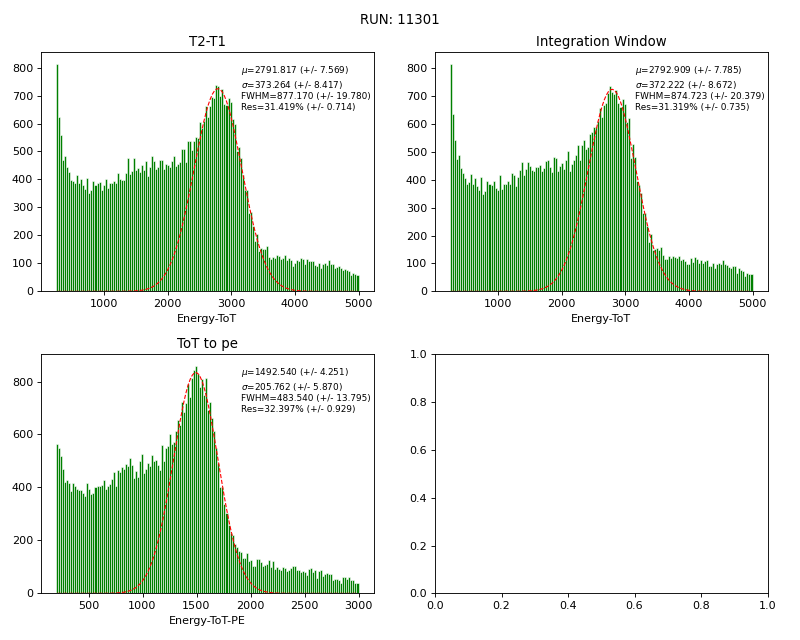

In [94]:
fig, axis = plt.subplots(2,2,figsize=(10,8))

#axis[0].hist(energy_window_array1,bins=50,range=[80,4000],log=False)
#axis[1].hist(energy_efine_array1,bins=50,range=[25,800],log=False)
#axis[0].set_title("Integ. Window Coincidence")
#axis[1].set_title("Efine Corrected Coincidence")

fig.suptitle("RUN: %i" % run)

axis[0,0].set_title("T2-T1")
coeff1=TPcal.gauss_fit2(out1,150,True,axis[0,0],"Energy-ToT","","",[0.6,0.95,"left"]
                 ,[250,5000],[2500,3500],[125,2900,300])

axis[0,1].set_title("integ_w")
coeff2=TPcal.gauss_fit2(out2,150,True,axis[0,1],"Energy-ToT","","",[0.6,0.95,"left"]
                 ,[250,5000],[2500,3500],[125,2900,300])

coeff3=TPcal.gauss_fit2(out3,150,True,axis[1,0],"Energy-ToT-PE","","",[0.6,0.95,"left"]
                 ,[200,3000],[1300,1800],[125,1500,50])


#axis[0,0].hist(out1,bins=150,range=[100,6000],log=False,alpha=0.8)
#axis[0,1].hist(out2,bins=150,range=[100,6000],log=False,alpha=0.6)
#axis[0,1].hist(out1,bins=150,range=[100,6000],log=False,alpha=0.2,color='r')
#axis[1,0].hist(out3,bins=180,range=[100,4000],log=False,alpha=0.8,color='r')
#axis[0,1].legend(("intg_w","T2-T1"))
axis[0,0].set_title("T2-T1")
axis[0,1].set_title("Integration Window")
axis[1,0].set_title("ToT to pe")
plt.tight_layout()

# Peak Scanner

low  = 2300
high = 3300
energy_w = df_out.groupby(['cluster','evt_number'])['intg_w_ToT'].sum()
df_filtered = df_out.loc[(energy_w>low) & (energy_w<high)]
energy3 = df_filtered.groupby(['cluster','evt_number'], as_index = False)['ToT_pe'].sum()
energy4 = df_filtered.groupby(['cluster','evt_number'], as_index = False)['intg_w_ToT'].sum()



fig, axis = plt.subplots(3,2,figsize=(9,9))
fig.suptitle(("RUN: %i" % run) + (" // PEAK = [%i , %i] " % (low,high)) )
axis[0,0].hist(df_filtered['ToT_pe'],bins=400,range=[0,200],alpha=0.8)
axis[0,0].set_title("ToT_pe")
axis[0,1].hist(energy3['ToT_pe'],bins=1600,range=[0,3000],alpha=0.8)
axis[0,1].set_title("Energy (using ToT_pe)")
axis[1,0].hist(df_filtered['intg_w_ToT'],bins=1600,range=[0,150],alpha=0.8)
axis[1,0].hist(df_filtered['intg_w'],bins=1600,range=[0,75],alpha=0.8)
axis[1,0].set_title("ToT")
axis[1,1].set_title("Energy (using intg_w_ToT)")
axis[1,1].hist(energy4,bins=400,range=[0,4000],alpha=0.8)
axis[2,0].set_title("Channels")
axis[2,0].hist(df_filtered['sensor_id'],bins=64,range=[0,64],alpha=0.8)

<IPython.core.display.Javascript object>


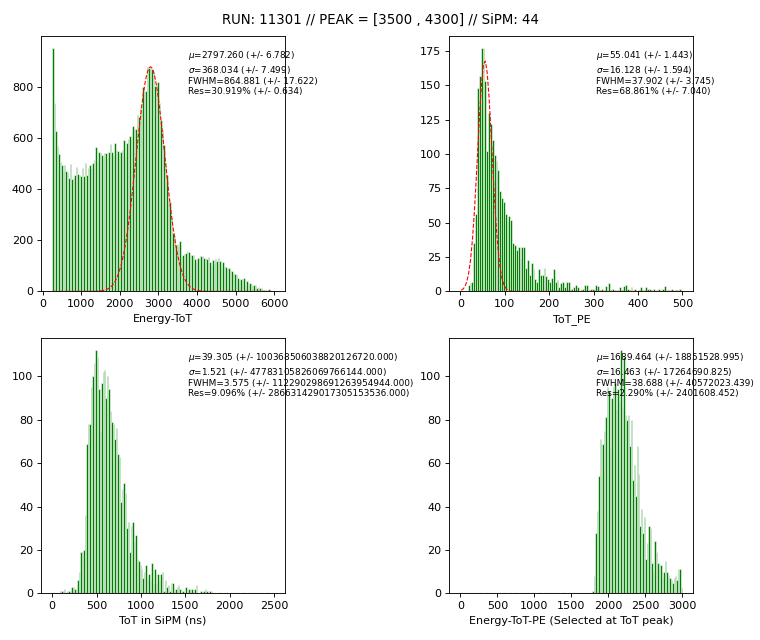

/volumedisk0/home/vherrero/PETALO_analysis/TOFPET_cal_lib.py:284: RuntimeWarning: divide by zero encountered in true_divide
  self.chisq = np.sum((((self.hist_f-self.hist_fit_f)**2)/self.hist_fit_f))
/volumedisk0/home/vherrero/PETALO_analysis/TOFPET_cal_lib.py:284: RuntimeWarning: invalid value encountered in true_divide
  self.chisq = np.sum((((self.hist_f-self.hist_fit_f)**2)/self.hist_fit_f))


In [102]:
fig, axis = plt.subplots(2,2,figsize=(9.5,8))
low  = 3500
high = 4300
sipm = 44

energy_w = df_out.groupby(['cluster','evt_number'])['intg_w_ToT'].sum()
df_filtered = df_out.loc[(energy_w>low) & (energy_w<high)]
ch_filtered = df_filtered.loc[df_filtered['sensor_id']==sipm]

energy3 = df_filtered.groupby(['cluster','evt_number'], as_index = False)['ToT_pe'].sum()


fig.suptitle(("RUN: %i" % run) + (" // PEAK = [%i , %i] // SiPM: %i" % (low,high,sipm)) )


coeff1=TPcal.gauss_fit2(out1,150,True,axis[0,0],"Energy-ToT","","",[0.6,0.95,"left"]
                 ,[250,6000],[2500,3500],[125,2900,300])


coeff2=TPcal.gauss_fit2(ch_filtered['ToT_pe'],120,True,axis[0,1],"ToT_PE","","",[0.6,0.95,"left"]
                 ,[0,500],[0,80],[125,50,20])


coeff3=TPcal.gauss_fit2(ch_filtered['intg_w_ToT']*5,150,True,axis[1,0],"ToT in SiPM (ns)","","",[0.6,0.95,"left"]
                 ,[0,2500],[10,500],[125,50,20])

coeff4=TPcal.gauss_fit2(energy3,150,True,axis[1,1],"Energy-ToT-PE (Selected at ToT peak)","","",[0.6,0.95,"left"]
                 ,[0,3000],[1300,2000],[125,1700,20])


#axis[0,1].hist(energy3['ToT_pe'],bins=1600,range=[0,2000],alpha=0.8)
#axis[0,1].set_title("Energy (using ToT_pe)")
#axis[1,0].hist(ch_filtered['intg_w_ToT'],bins=150,range=[0,180],alpha=0.8)
#axis[1,0].hist(ch_filtered['intg_w'],bins=150,range=[0,180],alpha=0.8)
#axis[1,0].set_title("ToT")
#axis[1,1].set_title("Energy (using intg_w_ToT)")
#axis[1,1].hist(energy4,bins=400,range=[0,4000],alpha=0.8)
plt.tight_layout()

<IPython.core.display.Javascript object>


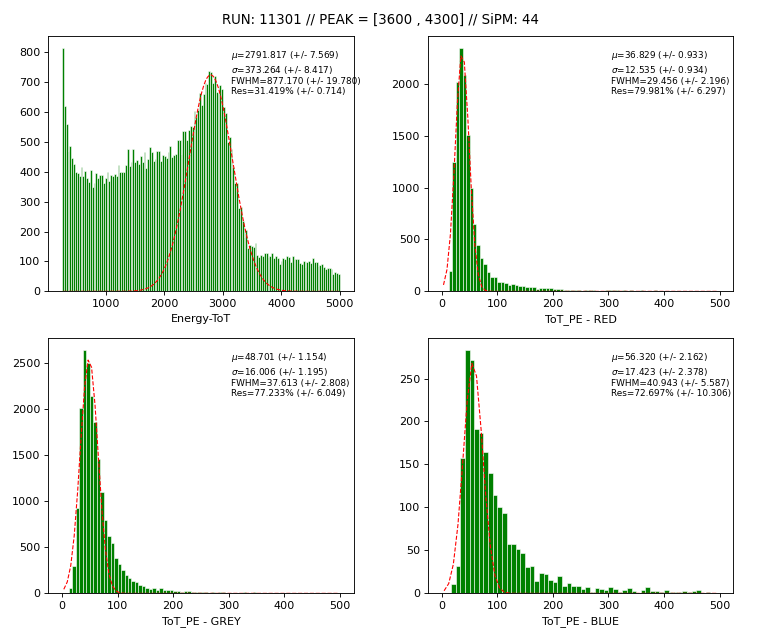

In [97]:
fig, axis = plt.subplots(2,2,figsize=(9.5,8))

low1  = 1000
high1 = 2200
low2  = 2200
high2 = 3500
low3  = 3600
high3 = 4300

sipm = 44

energy_w = df_out.groupby(['cluster','evt_number'])['intg_w_ToT'].sum()

df_filtered1 = df_out.loc[(energy_w>low1) & (energy_w<high1)]
df_filtered2 = df_out.loc[(energy_w>low2) & (energy_w<high2)]
df_filtered3 = df_out.loc[(energy_w>low3) & (energy_w<high3)]

ch_filtered1 = df_filtered1.loc[df_filtered1['sensor_id']==sipm]
ch_filtered2 = df_filtered2.loc[df_filtered2['sensor_id']==sipm]
ch_filtered3 = df_filtered3.loc[df_filtered3['sensor_id']==sipm]



fig.suptitle(("RUN: %i" % run) + (" // PEAK = [%i , %i] // SiPM: %i" % (low,high,sipm)) )


coeff1=TPcal.gauss_fit2(out1,150,True,axis[0,0],"Energy-ToT","","",[0.6,0.95,"left"]
                 ,[250,5000],[2500,3500],[125,2900,300])


coeff2=TPcal.gauss_fit2(ch_filtered1['ToT_pe'],80,True,axis[0,1],"ToT_PE - RED","","",[0.6,0.95,"left"]
                 ,[0,500],[0,80],[125,50,20])
coeff3=TPcal.gauss_fit2(ch_filtered2['ToT_pe'],80,True,axis[1,0],"ToT_PE - GREY","","",[0.6,0.95,"left"]
                 ,[0,500],[0,80],[125,50,20])
coeff4=TPcal.gauss_fit2(ch_filtered3['ToT_pe'],60,True,axis[1,1],"ToT_PE - BLUE","","",[0.6,0.95,"left"]
                 ,[0,500],[0,80],[125,50,20])


plt.tight_layout()

In [39]:
path_out             = "/home/vherrero/RESULTS/"
filename_processed   = "run_"+str(run)+"_results_e.h5"
with pd.HDFStore(path_out + filename_processed,'w',complib="zlib",complevel=4) as storage:
    df_out1 = pd.DataFrame(out1)
    df_out2 = pd.DataFrame(out2)
    df_out3 = pd.DataFrame(out3)
    storage.put('df_out',df_out,index=False,format='table',data_columns=True)
    storage.put('out1',df_out1)
    storage.put('out2',df_out2)
    storage.put('out3',df_out3)


In [40]:
df_out1

,0
0,10.277135
1,31.924881
2,14.442688
3,3058.253219
4,210.781739
...,...
454861,30.042320
454862,21.211641
454863,28.968617
454864,17.682833


In [41]:
energy1p,energy3p,df_outp = post_process("/home/vherrero/RESULTS/run_11301_results_e.h5","ToT_PE_conversion10b.h5")

6.2 209.8
New ToT_pe table


KeyboardInterrupt: 

In [ ]:
fig, axis = plt.subplots(2,2,figsize=(9.5,8))
lowp  = 2500
highp = 3300
sipmp = 44

energy_wp = df_outp.groupby(['cluster','evt_number'])['intg_w_ToT'].sum()
df_filteredp = df_outp.loc[(energy_wp>low) & (energy_wp<high)]
ch_filteredp = df_filteredp.loc[df_filteredp['sensor_id']==sipmp]


fig.suptitle(("RUN: %i" % run) + (" // PEAK = [%i , %i] // SiPM: %i" % (lowp,highp,sipmp)) )


coeff1=TPcal.gauss_fit2(energy1p,150,True,axis[0,0],"Energy-ToT","","",[0.6,0.95,"left"]
                 ,[250,5000],[2500,3500],[125,2900,300])


coeff2=TPcal.gauss_fit2(ch_filteredp['ToT_pe'],150,True,axis[0,1],"ToT_PE","","",[0.6,0.95,"left"]
                 ,[0,500],[0,80],[125,50,20])


coeff3=TPcal.gauss_fit2(ch_filteredp['intg_w_ToT'],150,True,axis[1,0],"ToT in SiPM","","",[0.6,0.95,"left"]
                 ,[0,500],[10,500],[125,50,20])

coeff4=TPcal.gauss_fit2(energy3p,150,True,axis[1,1],"Energy-ToT-PE","","",[0.6,0.95,"left"]
                 ,[250,3000],[1200,1860],[125,1500,300])

#axis[0,1].hist(energy3['ToT_pe'],bins=1600,range=[0,2000],alpha=0.8)
#axis[0,1].set_title("Energy (using ToT_pe)")
#axis[1,0].hist(ch_filtered['intg_w_ToT'],bins=150,range=[0,180],alpha=0.8)
#axis[1,0].hist(ch_filtered['intg_w'],bins=150,range=[0,180],alpha=0.8)
#axis[1,0].set_title("ToT")
#axis[1,1].set_title("Energy (using intg_w_ToT)")
#axis[1,1].hist(energy4,bins=400,range=[0,4000],alpha=0.8)
plt.tight_layout()

In [ ]:
len(df_outp)

# Events Plot

evt = hama_array[16]
evt2 = fbk_array[16]

fig, axis = plt.subplots(1,2,figsize=(10,4))

image=np.zeros((8,8))
for i in range(len(evt)):
    sipm = evt.iloc[i]['sensor_id']
    y = int(sipm // 10)-1
    x = int(sipm % 10)-1
    image[x,y] = evt.iloc[i]['intg_w']
axis[0].imshow(image)

image=np.zeros((8,8))
for i in range(len(evt2)):
    sipm = evt2.iloc[i]['sensor_id']
    y = int((sipm-100) // 10)-1
    x = int((sipm-100) % 10)-1
    image[x,y] = evt2.iloc[i]['intg_w']
axis[1].imshow(image)